<a href="https://colab.research.google.com/github/vanyagoncharov/CourseMLResourse/blob/main/SVM_with_others.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd


# from sklearn.datasets import make_classification
from sklearn import datasets

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from mlxtend.plotting import plot_decision_regions  # требуется установка mlxtend

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# загружаем набор данных
iris = datasets.load_iris()


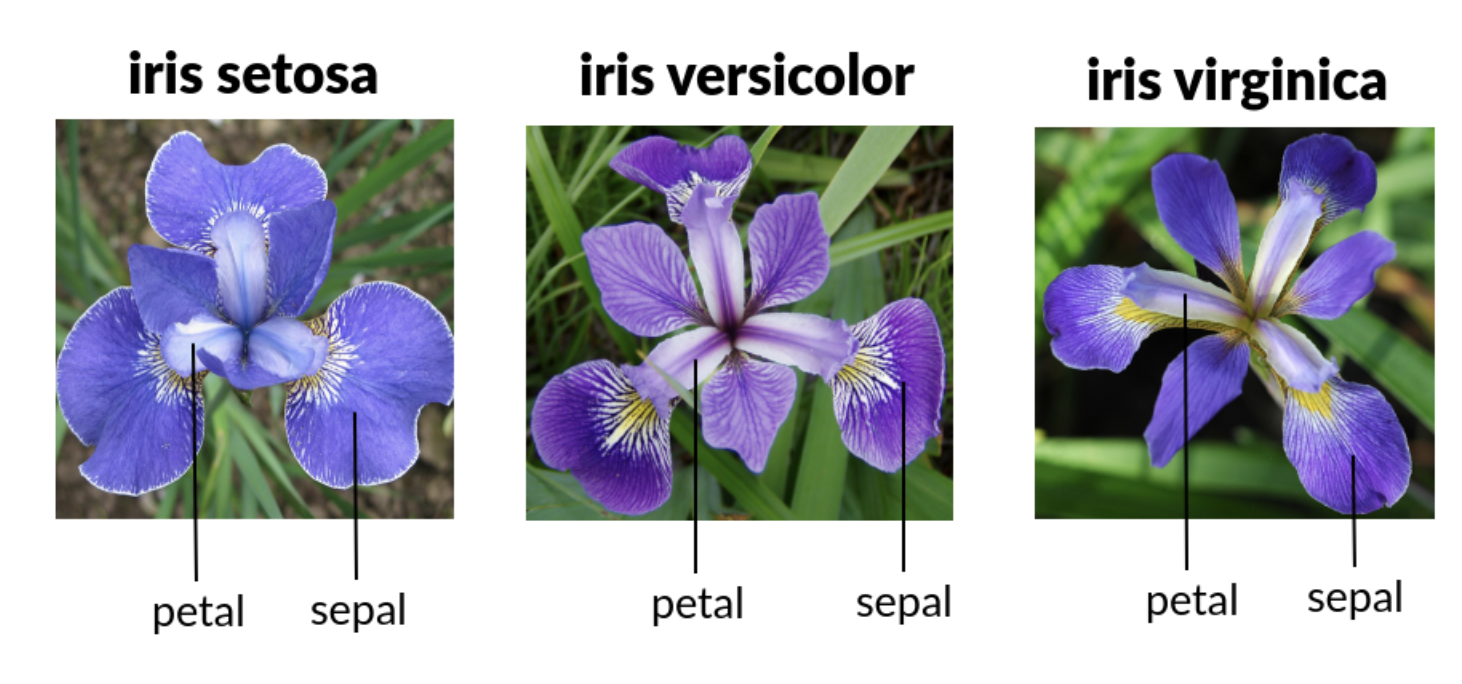

In [ ]:
# загрузим датасет с ирисами
data = datasets.load_iris()
X = pd.DataFrame(data["data"], columns=data["feature_names"])
y = data["target"]

#EDA

In [ ]:
# Размер датасета
print(f"В датасете по ирисам: {X.shape[0]} строк")

# Information about columns and data types
print(f"\n В датасете по ирисам {X.shape[1]} столбцов, из них :")
print(X.dtypes.value_counts())

В датасете по ирисам: 150 строк

 В датасете по ирисам 4 столбцов, из них :
float64    4
dtype: int64


In [ ]:
print("\n Статистика по столбцам:")
X.describe().T


 Статистика по столбцам:


,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


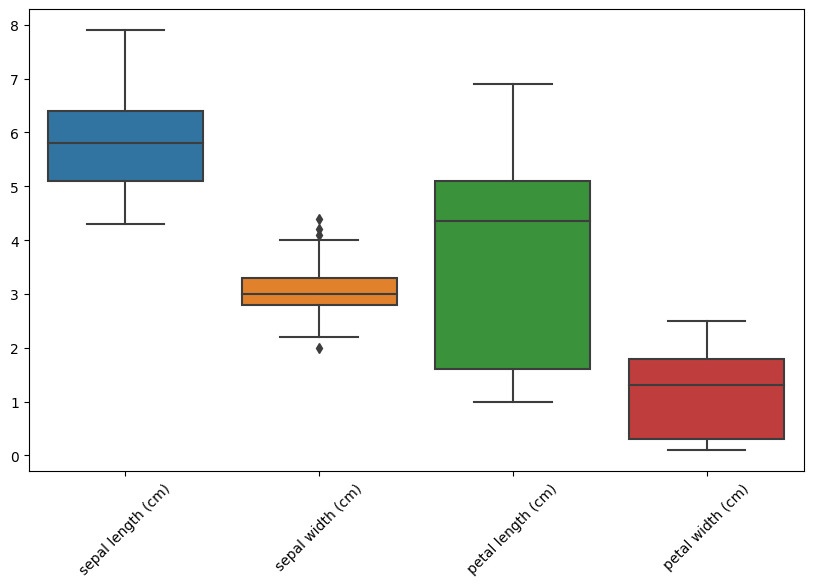

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.show()

**Вывод :**
- Датасет по ирисам небольшой, содержит 150 строк и 4 столбца
- Пропусков нет
- Выбросов нет

In [ ]:
# распределение целевой
print("\nTarget Class Distribution:")
pd.Series(y).value_counts()



Target Class Distribution:


0    50
1    50
2    50
dtype: int64

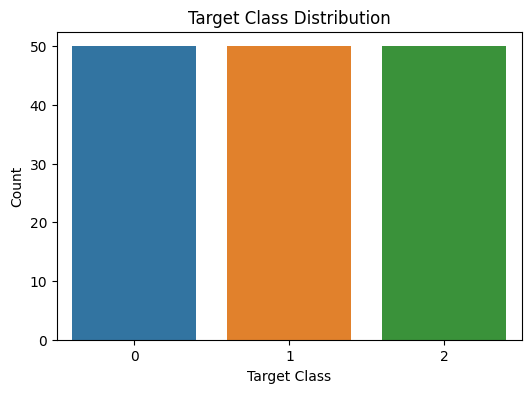

In [ ]:
# Bar plot for target class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=pd.Series(y))
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Target Class Distribution')
plt.show()

**Вывод:**

Целевая переменная распроделена равномерно , каждый класс равновероятен

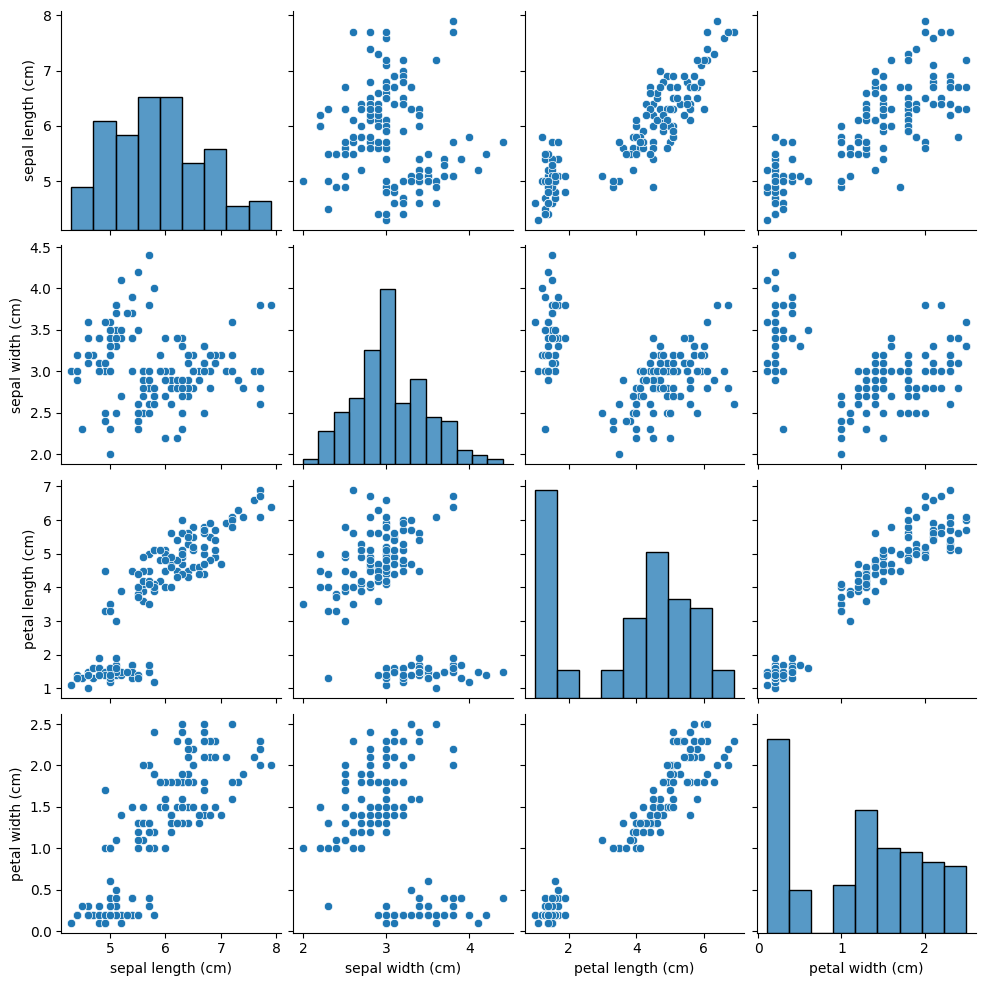

In [ ]:
# Проанализируем взаимосвязи между переменными
sns.pairplot(X)
plt.show()

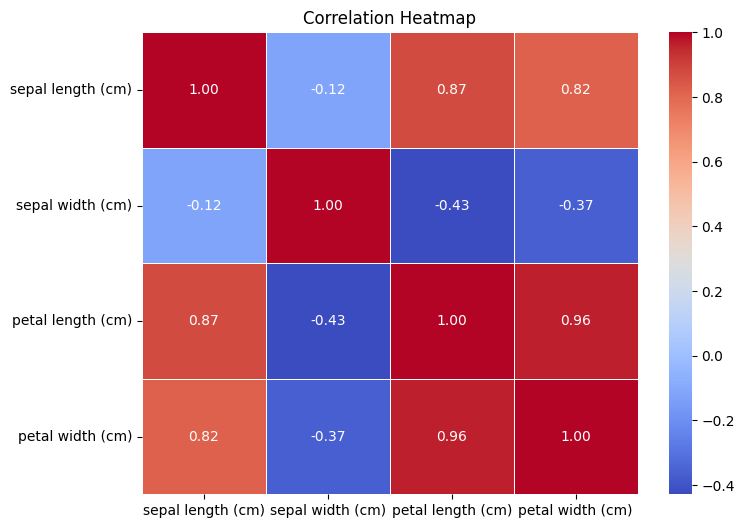

In [ ]:
# Построим матрицу корреляций
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
X.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

**Вывод**
В данных наблюдается высокая прямая корреляция между следующими признаками:


1.   sepal length (cm) и petal width (cm)
2.   petal length (cm) и petal width (cm)
3.   petal length (cm) и sepal length (cm)



**Цель данного ноутбука** сравнить методы классификации SVM, logistic regression и knn classification

По этой причине перейдём к задаче бинарной классификации: будем предсказывать принадлежность цветка к виду versicolor против принадлежности ко всем прочим видам.

Для этого перекодируйте зависимую переменную так, чтобы цветки вида versicolor имели метку 1, а прочих видов – метку -1.

In [ ]:
# Перекодировка
y_bin = (data["target"] == 1).astype(int)

Из всех признаковы выберем только 2 признака, чтобы можно было наглядно продемонстрировать работу алгоритмов (отрисовать зоны принятия решения в двумерной плоскости)

- Будем работать с двумя признаками: sepal length (cm) и sepal width (cm). Отделим их в отдельный датафрейм.


- Далее Разделим выборку на обучающую и тестовую, долю тестовой выборки выберем  равной 0.4.


- Также отмасштабируем выборки при помощи StandardScaler, то есть приведем наши данные к к данным со средним = 0 и среднеквадратическим отклонением = 1



In [ ]:
np.random.seed(123)

X = X[["sepal length (cm)", "sepal width (cm)"]]

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, train_size=0.6, stratify=y_bin)

# Отмасштабируйте признаки
ss = StandardScaler() # (x-m)/sigma

X_train = ss.fit_transform(X_train)

X_test = ss.transform(X_test)


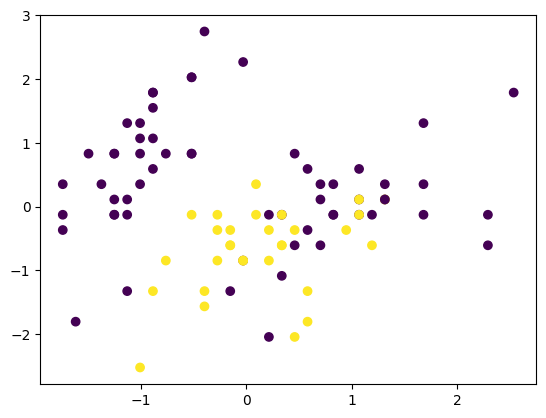

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);

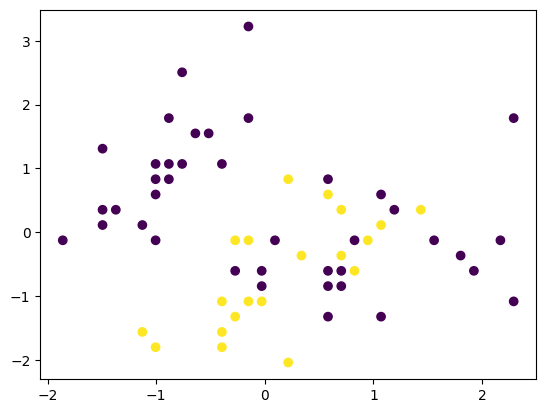

In [ ]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test);

In [ ]:
# Функция для построения графиков решающих областей
def plot_decision_boundary(model, X, y):
    # Параметры для графика
    h = .02  # Шаг сетки
    cmap = plt.cm.RdYlBu
    markers = 's^o'  # Маркеры для классов

    # Обучение модели
    model.fit(X, y)

    # Размеры графика
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Предсказание значений на сетке
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Построение контуров
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=cmap)

    # Разметка классов
    for i, c in zip(range(2), markers):
        plt.scatter(X[y == i][:, 0], X[y == i][:, 1], marker=c, label=f"Class {i}")

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Regions ({type(model).__name__})')
    plt.legend()
    plt.show()


In [ ]:
# Функция для расчета метрик и построения кривой ROC
def calculate_metrics_and_plot_roc(model, X_train, y_train, X_test, y_test):
    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание на обучающей и тестовой выборке
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Расчет метрик precision и recall
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)

    print(f"Training Precision: {train_precision:.2f}")
    print(f"Training Recall: {train_recall:.2f}")
    print(f"Test Precision: {test_precision:.2f}")
    print(f"Test Recall: {test_recall:.2f}")

    metrics =  {'params': ['Training_Precision', 'Test_Precision','Training_Recall', 'Test_Recall'],
                'values': [train_precision, test_precision, train_recall, test_recall]}

    # Расчет ROC-AUC на тестовой выборке
    try:
      pred_test = model.predict_proba(X_test)
      pred_train = model.predict_proba(X_train)
      roc_auc_test = roc_auc_score(y_test, pred_test[:, 1])
      roc_auc_train = roc_auc_score(y_train, pred_train[:, 1])
      print(f"ROC-AUC_test = : {roc_auc_test:.2f} и ROC-AUC_train = : {roc_auc_train:.2f}")

      # Построение кривой ROC
      fpr_test, tpr_test, _ = roc_curve(y_test, pred_test[:, 1])
      fpr_train, tpr_train, _ = roc_curve(y_train, pred_train[:, 1])
      plt.figure()
      plt.plot(fpr_test, tpr_test, color='blue', lw=2, label = 'ROC Curve test')
      plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label = 'ROC Curve test')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.legend()
      plt.title(f'ROC Curve ({type(model).__name__})')
      plt.show()
    except Exception as e:
      print(e)
    return metrics




##KNN

In [ ]:
# Построение модели k-Nearest Neighbors (kNN)
knn_model = KNeighborsClassifier()

In [ ]:
# поиск параметров с помощью перебора
params = {'n_neighbors': [1, 3, 5, 7, 9]}

best_score = 0
# best_n_neighbors = 0

for k in params['n_neighbors']:
    knn_model.set_params(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train, y_train, cv=5)
    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score
        best_n_neighbors = k

In [ ]:
best_n_neighbors

3

In [ ]:
# Задаем сетку параметров для значения "n_neighbors", которое мы хотим исследовать
param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}  # Пример значений, можно изменить диапазон по необходимости

# Создаем объект GridSearchCV с моделью KNN и сеткой параметров
grid_search = GridSearchCV(knn_model, param_grid, cv=5)  # Параметр cv определяет количество фолдов в кросс-валидации

# Обучаем модель на данных с помощью кросс-валидации
grid_search.fit(X_train, y_train)

# Получаем лучшее найденное значение параметра "n_neighbors" в результате кросс-валидации
best_n_neighbors = grid_search.best_params_['n_neighbors']
print('best_n_neighbors =', best_n_neighbors)


best_n_neighbors = 3


In [ ]:
best_knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)

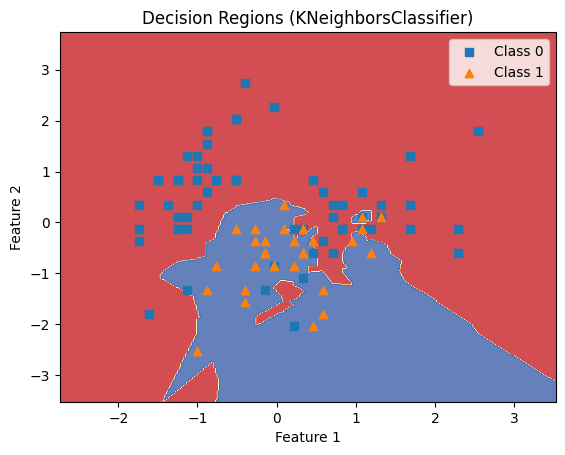

In [ ]:
plot_decision_boundary(best_knn_model, X_train, y_train)

Training Precision: 0.77
Training Recall: 0.80
Test Precision: 0.69
Test Recall: 0.55
ROC-AUC_test = : 0.78 и ROC-AUC_train = : 0.93


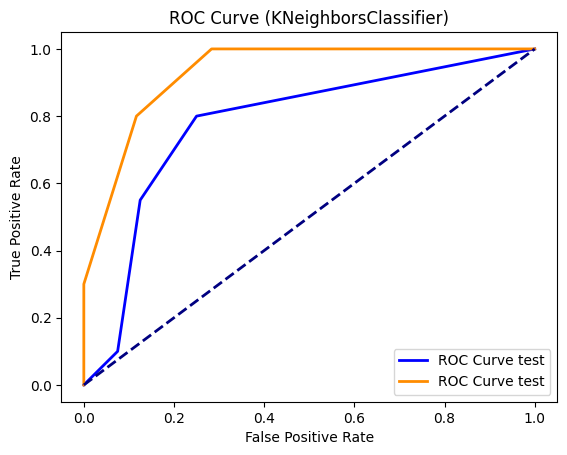

In [ ]:
metrics_knn = calculate_metrics_and_plot_roc(best_knn_model, X_train, y_train, X_test, y_test)

**Вывод**


k ближайщих соседей сильно переобучился, это видно и по графику ROC кривой, и по метрикам ROC-AUC, Precision, Recall

In [ ]:
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l2','l1',],
              'solver': ['liblinear','saga']
              }

# Создаем модель логистической регрессии
logreg_model = LogisticRegression(max_iter = 100000)

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(logreg_model, param_grid, cv=5)  # cv указывает количество блоков для кросс-валидации

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train, y_train)

# Получаем лучшее значение параметра C, найденное в процессе кросс-валидации
# best_params = grid_search.best_params_[param_grid]
print('Лучшее значение параметра:', grid_search.best_params_)


Лучшее значение параметра: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


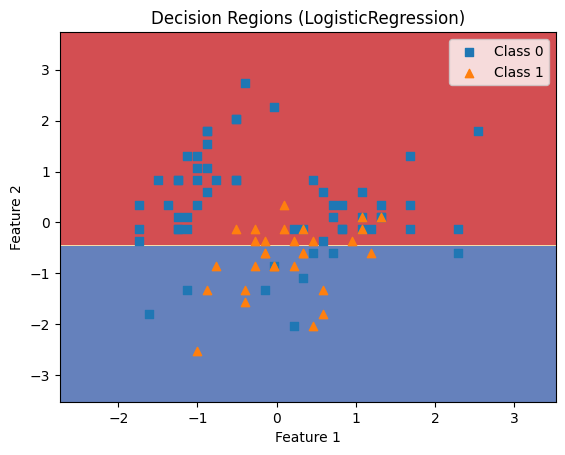

In [ ]:

# Построение модели логистической регрессии
logreg_model = LogisticRegression( max_iter=1000, **grid_search.best_params_)
plot_decision_boundary(logreg_model, X_train, y_train)

Training Precision: 0.65
Training Recall: 0.57
Test Precision: 0.48
Test Recall: 0.50
ROC-AUC_test = : 0.75 и ROC-AUC_train = : 0.83


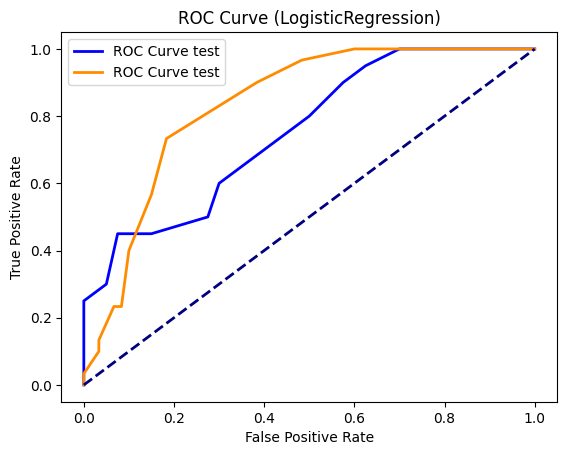

In [ ]:
metrics_logreg  = calculate_metrics_and_plot_roc(logreg_model, X_train, y_train, X_test, y_test)

**Вывод**

Логистическая регрессия переобучена, заметим, что  меньше, чем KNN.

Попробуем построить полиномиальную регрессию, может все изменится? 😊

In [ ]:
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l2','l1',],
              'solver': ['liblinear','saga']
              }
from sklearn.preprocessing import PolynomialFeatures

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly2.fit_transform(X_train)
X_test_poly = poly2.fit_transform(X_test)
# Fit Linear model with poly features
poly_model = LogisticRegression(max_iter = 100000)

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(poly_model, param_grid, cv=5)  # cv указывает количество блоков для кросс-валидации

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train_poly, y_train)

# Получаем лучшее значение параметра C, найденное в процессе кросс-валидации
print('Лучшее значение параметра:', grid_search.best_params_)


Лучшее значение параметра: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
poly_model = LogisticRegression(max_iter = 100000, **grid_search.best_params_)
poly_model.fit(X_train_poly, y_train)


LogisticRegression(C=1, max_iter=100000, solver='liblinear')

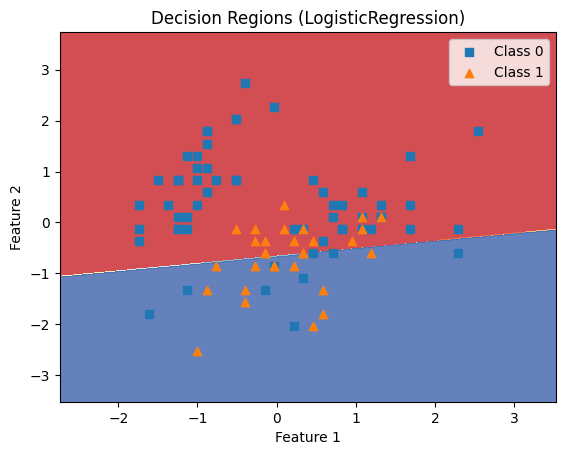

In [ ]:
plot_decision_boundary(poly_model, X_train, y_train)

Training Precision: 0.59
Training Recall: 0.43
Test Precision: 0.53
Test Recall: 0.50
ROC-AUC_test = : 0.76 и ROC-AUC_train = : 0.83


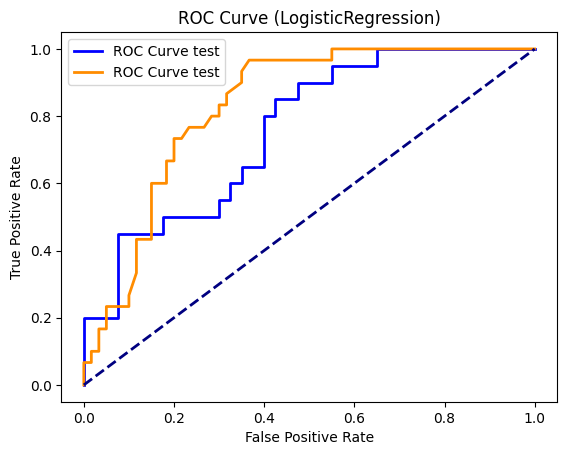

In [ ]:
metrics_poly_logreg  = calculate_metrics_and_plot_roc(poly_model, X_train, y_train, X_test, y_test)

**Вывод**

Полиномиальная регрессия не помогла нам, переобучение сохранилось 😥

Попробуем SVM дальше

In [ ]:
from sklearn.svm import SVC
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 0.4, 0.5, 0.7, 0.8, 0.9, 1, 2, 3, 10, 100],
              }

# Создаем модель логистической регрессии
svm_model = SVC(kernel='linear', C=0.0)

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(svm_model, param_grid, cv=5)  # cv указывает количество блоков для кросс-валидации

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train, y_train)

# Получаем лучшее значение параметра C, найденное в процессе кросс-валидации
# best_params = grid_search.best_params_[param_grid]
print('Лучшее значение параметра:', grid_search.best_params_)


# Создаем модель логистической регрессии с лучшим значением C
best_svm_model = SVC(kernel='linear', **grid_search.best_params_)

Лучшее значение параметра: {'C': 0.7}


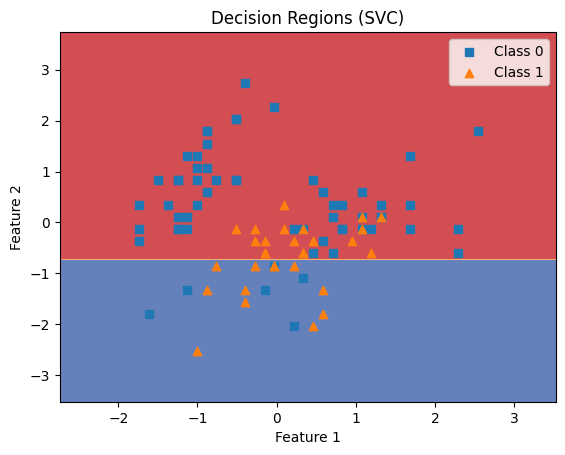

In [ ]:
plot_decision_boundary(best_svm_model, X_train, y_train)

In [ ]:
metrics_svm_linear  = calculate_metrics_and_plot_roc(best_svm_model, X_train, y_train, X_test, y_test)

Training Precision: 0.67
Training Recall: 0.40
Test Precision: 0.60
Test Recall: 0.45
predict_proba is not available when  probability=False


**Вывод**

По метрикам качества Precision и Recall видно, что переобучение уменьшилось, SVM линейный пока выигрывает

Может мы еще сможем улучшить модель? Например, добавим нелинейности в SVM

In [ ]:
from sklearn.svm import SVC
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'kernel':['linear', 'poly', 'rbf', 'sigmoid',]
              }

# Создаем модель логистической регрессии
svm_model = SVC(kernel='linear')

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(svm_model, param_grid, cv=5)  # cv указывает количество блоков для кросс-валидации

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train, y_train)

# Получаем лучшее значение параметра C, найденное в процессе кросс-валидации
# best_params = grid_search.best_params_[param_grid]
print('Лучшее значение параметра:', grid_search.best_params_)


# Создаем модель логистической регрессии с лучшим значением C
best_svm_model = SVC(**grid_search.best_params_)

Лучшее значение параметра: {'C': 1, 'kernel': 'rbf'}


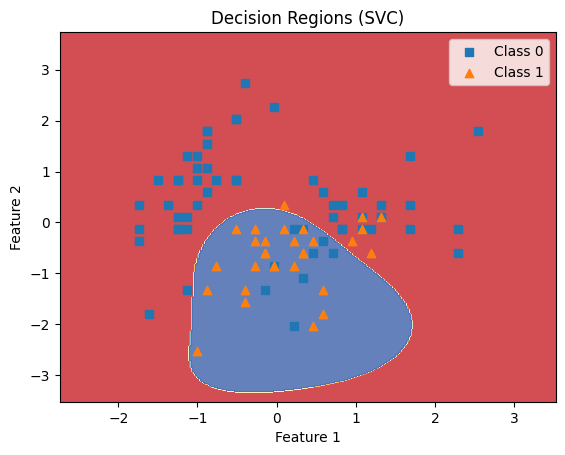

In [ ]:
plot_decision_boundary(best_svm_model, X_train, y_train)

In [ ]:
metrics_svm_not_linear  = calculate_metrics_and_plot_roc(best_svm_model, X_train, y_train, X_test, y_test)

Training Precision: 0.73
Training Recall: 0.80
Test Precision: 0.57
Test Recall: 0.65
predict_proba is not available when  probability=False


**Вывод**

Нет, добавление нелинейности в SVM не помогло, наоброт только все испортило.




**Соберем все результаты в одну таблицу, чтобы было проще сравнивать алгоритмы**

In [ ]:
metrics_svm_not_linear['metrics'] = ['metrics_svm_not_linear' for i in range(4)]

metrics_svm_linear['metrics'] = ['metrics_svm_linear' for i in range(4)]

metrics_poly_logreg['metrics'] = ['metrics_poly_logreg' for i in range(4)]

metrics_logreg['metrics'] = ['metrics_logreg' for i in range(4)]
metrics_knn['metrics'] = ['metrics_knn' for i in range(4)]

In [ ]:
df_stat = pd.concat([pd.DataFrame(metrics_svm_not_linear),
                    pd.DataFrame(metrics_svm_linear),
                    pd.DataFrame(metrics_poly_logreg),
                    pd.DataFrame(metrics_logreg),
                    pd.DataFrame(metrics_knn)])

In [ ]:
df_stat = df_stat.pivot_table(columns = 'params',
                            index='metrics',
                            values='values').reset_index()[['metrics','Test_Precision',	'Training_Precision',
                                                            'Test_Recall',	'Training_Recall']]
df_stat['dif_Precision'] = round((df_stat['Test_Precision'] - df_stat['Training_Precision'])/df_stat['Training_Precision'],2)

df_stat['dif_Recall'] = round((df_stat['Test_Recall'] - df_stat['Training_Recall'])/df_stat['Training_Recall'],2)
df_stat

params,metrics,Test_Precision,Training_Precision,Test_Recall,Training_Recall,dif_Precision,dif_Recall
0,metrics_knn,0.687500,0.774194,0.55,0.800000,-0.11,-0.31
1,metrics_logreg,0.476190,0.653846,0.50,0.566667,-0.27,-0.12
2,metrics_poly_logreg,0.526316,0.590909,0.50,0.433333,-0.11,0.15
3,metrics_svm_linear,0.600000,0.666667,0.45,0.400000,-0.10,0.12
4,metrics_svm_not_linear,0.565217,0.727273,0.65,0.800000,-0.22,-0.19



Получается, что наиболее точным и непереобученным алгоритмом оказался SVM линейный, по параметрам dif_Precision и dif_Recall видно, что разница между параметрами на трейне и тесте наименьшая по сравнению со всемит остальными алгоритмами